# About SpaceNet

[SpaceNet](https://spacenetchallenge.github.io/) is a corpus of commercial satellite imagery and labeled training data to use for machine learning research. The dataset is currently hosted as an [Amazon Web Services (AWS) Public Dataset](https://aws.amazon.com/public-datasets/spacenet/).

The current SpaceNet corpus includes thousands of square kilometers of high resolution imagery collected from DigitalGlobe’s commercial satellites which includes 8-band multispectral data. This dataset is being made public to advance the development of algorithms to automatically extract geometric features such as roads, building footprints, and points of interest using satellite imagery. 

The currently available Areas of Interest (AOI) are:
- Rio de Janeiro
- Paris
- Las Vegas
- Shanghai
- Khartoum. 

The satellite imagery, along with training data, is provided via a collaboration between DigitalGlobe, CosmiQ Works, and NVIDIA.

# Rio de Janeiro labelled satellite imagery from SpaceNet

See https://spacenetchallenge.github.io/AOI_Lists/AOI_1_Rio.html

In [1]:
from IPython.display import HTML
url = 'https://spacenetchallenge.github.io/AOI_Lists/AOI_1_Rio.html'
iframe = '<iframe src=' + url + ' width=100% height=600></iframe>'
HTML(iframe)

# Set up Amazon Web Services Command Line Interface

In order to download the dataset, you'll need to install and configure the AWS command line interface.

See here: https://aws.amazon.com/cli/

First, pip install the aws command line interface:

In [2]:
#!pip install awscli

Next, configure the cli with you access key and secret access key from AWS console.

Something like this:

    !aws configure
    AWS Access Key ID [None]: "YOUR ACCESS KEY"
    AWS Secret Access Key [None]: "YOUR SECRET ACCESS KEY"
    Default region name [None]: us-west-2
    Default output format [None]: json

# View the contents of the dataset

In [3]:
!aws s3 ls spacenet-dataset/AOI_1_Rio/ --request-payer requester

                           PRE processedData/
                           PRE srcData/
                           PRE vectorData/


# Download the data

Download 200m x 200m tiles of AOI (3.4 GB) and building footprints

In [ ]:
%%time
!aws s3api get-object --bucket spacenet-dataset --key AOI_1_Rio/processedData/processedBuildingLabels.tar.gz --request-payer requester processedBuildingLabels.tar.gz

# Unzip the data

Unzip the main folder

In [ ]:
!tar -xvzf processedBuildingLabels.tar.gz

Unzip the 3band satellite images

In [ ]:
!tar -xvzf processedBuildingLabels/3band.tar.gz

Unzip the geojson containing labels

In [ ]:
!tar -xvzf processedBuildingLabels/vectordata/geojson.tar.gz

# How many images are there?

In [74]:
import os
from os.path import join

In [5]:
images_folder = "3band"
labels_folder = "geojson"

In [6]:
print(len([name for name in os.listdir(images_folder)]), "satellite images")

6940 satellite images


In [7]:
print(len([name for name in os.listdir(labels_folder)]), "geojson labels")

6940 geojson labels


# Read a few of the images into arrays

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

Try reading the first image.

In [9]:
img=np.array(Image.open(join(images_folder, os.listdir(images_folder)[0])))

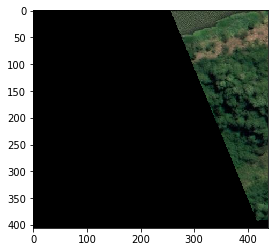

In [10]:
plt.imshow(img);

Here is the last image.

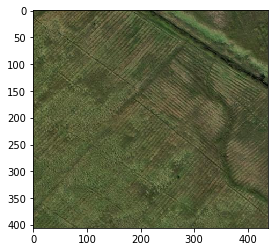

In [11]:
plt.imshow(np.array(Image.open(join(images_folder, os.listdir(images_folder)[-1]))));

# Read all the images into list of arrays

In [12]:
images = [np.array(Image.open(join(images_folder, i)).convert('L')) for i in os.listdir(images_folder)]

In [13]:
print(len(images), "images")

6940 images


# Resize some of the images so that they are all the same size

Some images have shape of (406, 438), others have shape of (406, 439).

Change the (406, 439)'s to (406, 438).

In [14]:
for i in range(len(images)):
    if images[i].shape[1] == 439:
        images[i] = np.delete(images[i], 439-1, axis=1)

Change the (407, 438)'s to (406, 438)'s.

In [15]:
for i in range(len(images)):
    if images[i].shape[0] == 407:
        images[i] = np.delete(images[i], 407-1, axis=0)

# Downsample the images so they are smaller.

In [16]:
from skimage.transform import downscale_local_mean

4x downsampling.

In [17]:
downscaled_images = []
for i in range(len(images)):
    downscaled_images.append(downscale_local_mean(images[i], (4,4)))

In [18]:
downscaled_images[0].shape

(102, 110)

Original image:

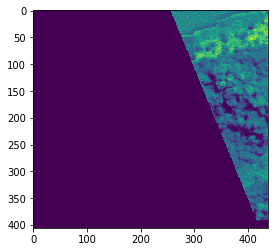

In [19]:
plt.imshow(images[0]);

Downscaled image:

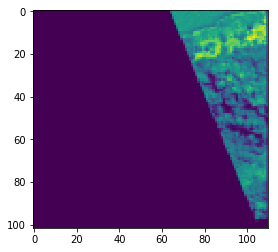

In [20]:
plt.imshow(downscaled_images[0]);

# Convert this list of downscaled arrays into a 3D array

In [21]:
shape = list(downscaled_images[0].shape)
shape[:0] = [len(downscaled_images)]
array_of_images = np.concatenate(downscaled_images).reshape(shape)

In [22]:
array_of_images.shape

(6940, 102, 110)

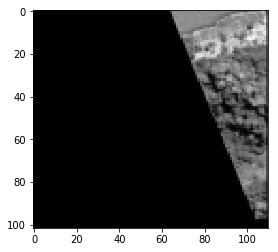

In [23]:
plt.imshow(array_of_images[0], cmap="gray");

# Parse the geojson labels for 1 = building, 0 = no building

In [24]:
import json

Read in all the geojsons.

In [25]:
labels = [json.load(open(join(labels_folder, i))) for i in os.listdir(labels_folder)]

# Create an array containing 1 = buildings, 0 = no buildings

In [26]:
def parse_labels(labels):
    
    results = []
    
    for label in labels:
        
        features = label['features']
        
        # If no features at all, append 0
        if len(features) == 0:
            results.append(0)
            
        # Otherwise, look for building property
        else:
            buildings_in_this_label = []
            for feature in features:
                properties = feature['properties']
                if 'building' in properties.keys():
                    if properties['building'] == 'yes':
                        buildings_in_this_label.append(1)
                    else:
                        buildings_in_this_label.append(0)
                else:
                    buildings_in_this_label.append(0)
            
            # If there is at least one building in this label, append 1
            if sum(buildings_in_this_label) > 0:
                results.append(1)
                
            # Otherwise append 0
            else:
                results.append(0)
                        
    array = np.array(results)
    return array

In [27]:
buildings_no_buildings = parse_labels(labels)

In [28]:
print(buildings_no_buildings.sum(), "of the", buildings_no_buildings.shape[0], "images contain buildings")

4302 of the 6940 images contain buildings


# Frame this as a machine learning problem

In [29]:
X = array_of_images
y = buildings_no_buildings

In [30]:
X.shape

(6940, 102, 110)

In [31]:
y.shape

(6940,)

# Split data into training and testing data

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
X_train.shape

(5205, 102, 110)

In [35]:
y_train.shape

(5205,)

In [36]:
X_test.shape

(1735, 102, 110)

In [37]:
y_test.shape

(1735,)

# Simple Convolutional Neural Network

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [39]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [40]:
# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Next we need to load the dataset and reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [pixels][width][height].

In [41]:
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, X_train[0].shape[0], X_train[0].shape[1]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, X_test[0].shape[0], X_test[0].shape[1]).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [42]:
def simple_cnn():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(1, X_train.shape[2], X_train.shape[3]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [43]:
%%time
# build the model
model_2 = simple_cnn()
# Fit the model
history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, verbose=2)
# Final evaluation of the model
scores = model_2.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 5205 samples, validate on 1735 samples
Epoch 1/10
 - 119s - loss: 1.9006 - acc: 0.6697 - val_loss: 0.4928 - val_acc: 0.7055
Epoch 2/10
 - 113s - loss: 0.3761 - acc: 0.8171 - val_loss: 0.4867 - val_acc: 0.7579
Epoch 3/10
 - 112s - loss: 0.3309 - acc: 0.8488 - val_loss: 0.3015 - val_acc: 0.8599
Epoch 4/10
 - 111s - loss: 0.2771 - acc: 0.8784 - val_loss: 0.3095 - val_acc: 0.8582
Epoch 5/10
 - 113s - loss: 0.2466 - acc: 0.8938 - val_loss: 0.2856 - val_acc: 0.8663
Epoch 6/10
 - 113s - loss: 0.2077 - acc: 0.9147 - val_loss: 0.3659 - val_acc: 0.8484
Epoch 7/10
 - 113s - loss: 0.1894 - acc: 0.9256 - val_loss: 0.3325 - val_acc: 0.8553
Epoch 8/10
 - 113s - loss: 0.1607 - acc: 0.9389 - val_loss: 0.3374 - val_acc: 0.8542
Epoch 9/10
 - 113s - loss: 0.1303 - acc: 0.9552 - val_loss: 0.3345 - val_acc: 0.8599
Epoch 10/10
 - 114s - loss: 0.1022 - acc: 0.9685 - val_loss: 0.3704 - val_acc: 0.8553
CNN Error: 14.47%
CPU times: user 2h 3min 16s, sys: 4min 2s, total: 2h 7min 18s
Wall time: 19min 9s


In [44]:
predictions = model_2.predict_classes(X_test, batch_size=10)

In [46]:
def classify_image(i, predictions, X=X, y=y):
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.25, random_state=42)
    plt.imshow(X_test_orig[i])
    print("prediction:", ['no_building', 'building'][predictions[i]])
    print("actual:", ['no_building', 'building'][y_test_orig[i]])

prediction: building
actual: building


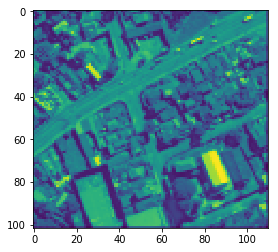

In [47]:
classify_image(0, predictions)

prediction: building
actual: no_building


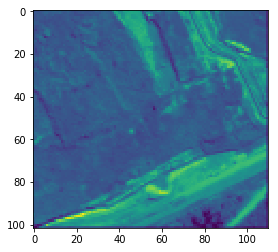

In [54]:
classify_image(80, predictions)

prediction: no_building
actual: no_building


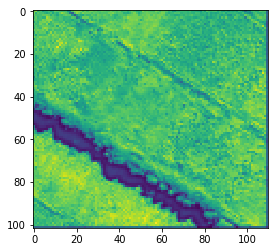

In [56]:
classify_image(500, predictions)

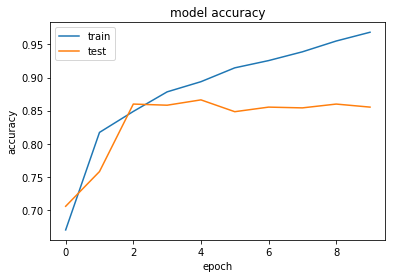

In [49]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

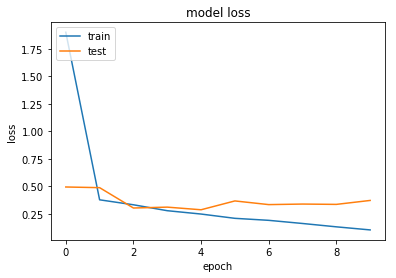

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Save model weights.

In [51]:
model_2.save(join("models", "model_2.h5"))

# Simple CNN with Batch size = 200

In [70]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# reshape to be [samples][bands][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, X_train[0].shape[0], X_train[0].shape[1]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, X_test[0].shape[0], X_test[0].shape[1]).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [71]:
%%time
# build the model
model_4 = simple_cnn()
# Fit the model
history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model_4.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 5205 samples, validate on 1735 samples
Epoch 1/10
 - 130s - loss: 3.4627 - acc: 0.6063 - val_loss: 0.5145 - val_acc: 0.7712
Epoch 2/10
 - 128s - loss: 0.4531 - acc: 0.7662 - val_loss: 0.4112 - val_acc: 0.7937
Epoch 3/10
 - 132s - loss: 0.3696 - acc: 0.8227 - val_loss: 0.3436 - val_acc: 0.8363
Epoch 4/10
 - 128s - loss: 0.3188 - acc: 0.8565 - val_loss: 0.3268 - val_acc: 0.8524
Epoch 5/10
 - 127s - loss: 0.2853 - acc: 0.8749 - val_loss: 0.2977 - val_acc: 0.8588
Epoch 6/10
 - 124s - loss: 0.2640 - acc: 0.8886 - val_loss: 0.4097 - val_acc: 0.8277
Epoch 7/10
 - 131s - loss: 0.2731 - acc: 0.8822 - val_loss: 0.2949 - val_acc: 0.8634
Epoch 8/10
 - 134s - loss: 0.2206 - acc: 0.9112 - val_loss: 0.3571 - val_acc: 0.8403
Epoch 9/10
 - 128s - loss: 0.2088 - acc: 0.9164 - val_loss: 0.2976 - val_acc: 0.8703
Epoch 10/10
 - 133s - loss: 0.1743 - acc: 0.9366 - val_loss: 0.2955 - val_acc: 0.8646
CNN Error: 13.54%
CPU times: user 2h 10min 19s, sys: 7min 3s, total: 2h 17min 23s
Wall time: 21min 54

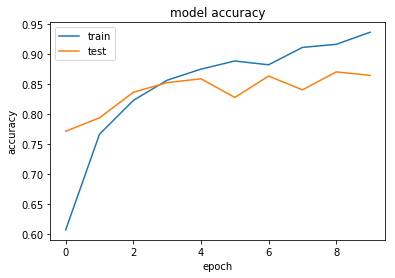

In [73]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Larger CNN

In [84]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# reshape to be [samples][bands][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, X_train[0].shape[0], X_train[0].shape[1]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, X_test[0].shape[0], X_test[0].shape[1]).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [63]:
# define the larger model
def larger_cnn():
    # create model
    model = Sequential()
    model.add(Conv2D(50, (5, 5), input_shape=(1, X_train.shape[2], X_train.shape[3]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [75]:
# define the larger model
def largerer_cnn():
    # create model
    model = Sequential()
    
    model.add(Conv2D(50, (5, 5), input_shape=(1, X_train.shape[2], X_train.shape[3]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [88]:
# define the larger model
def largererer_cnn():
    # create model
    model = Sequential()
    
    model.add(Conv2D(50, (5, 5), input_shape=(1, X_train.shape[2], X_train.shape[3]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(5, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [76]:
%%time
# build the model
model_3 = largerer_cnn()
# Fit the model
history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, verbose=2)
# Final evaluation of the model
scores = model_3.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 5205 samples, validate on 1735 samples
Epoch 1/10
 - 221s - loss: 0.5375 - acc: 0.7059 - val_loss: 0.3981 - val_acc: 0.8548
Epoch 2/10
 - 222s - loss: 0.3372 - acc: 0.8713 - val_loss: 0.3092 - val_acc: 0.8657
Epoch 3/10
 - 225s - loss: 0.2788 - acc: 0.8828 - val_loss: 0.2569 - val_acc: 0.8893
Epoch 4/10
 - 226s - loss: 0.2565 - acc: 0.8928 - val_loss: 0.2462 - val_acc: 0.8934
Epoch 5/10
 - 225s - loss: 0.2588 - acc: 0.8905 - val_loss: 0.2644 - val_acc: 0.8899
Epoch 6/10
 - 225s - loss: 0.2365 - acc: 0.9001 - val_loss: 0.2574 - val_acc: 0.8928
Epoch 7/10
 - 225s - loss: 0.2329 - acc: 0.9034 - val_loss: 0.2357 - val_acc: 0.8963
Epoch 8/10
 - 224s - loss: 0.2359 - acc: 0.9036 - val_loss: 0.2454 - val_acc: 0.8974
Epoch 9/10
 - 226s - loss: 0.2232 - acc: 0.9114 - val_loss: 0.2549 - val_acc: 0.8957
Epoch 10/10
 - 224s - loss: 0.2104 - acc: 0.9132 - val_loss: 0.2445 - val_acc: 0.8951
Large CNN Error: 10.49%
CPU times: user 4h 5min 27s, sys: 14min 44s, total: 4h 20min 11s
Wall time: 3

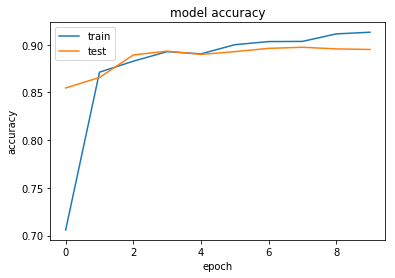

In [77]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

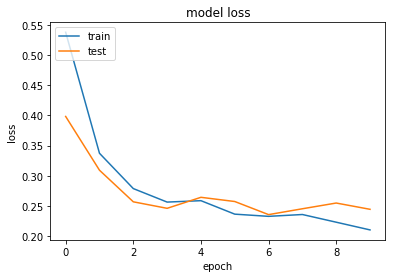

In [78]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
%%time
# build the model
model_4 = largererer_cnn()
# Fit the model
history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=100, verbose=2)
# Final evaluation of the model
scores = model_4.evaluate(X_test, y_test, verbose=0)
print("Largererer CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 5205 samples, validate on 1735 samples
Epoch 1/50


In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
%%time
# build the model
model_3 = simple_cnn()
# Fit the model
history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=50, verbose=2)
# Final evaluation of the model
scores = model_3.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 5205 samples, validate on 1735 samples
Epoch 1/10
 - 120s - loss: 0.7055 - acc: 0.7493 - val_loss: 0.3058 - val_acc: 0.8582
Epoch 2/10
 - 118s - loss: 0.2878 - acc: 0.8719 - val_loss: 0.3436 - val_acc: 0.8329
Epoch 3/10
 - 118s - loss: 0.2353 - acc: 0.9037 - val_loss: 0.2993 - val_acc: 0.8634
Epoch 4/10
 - 119s - loss: 0.1612 - acc: 0.9376 - val_loss: 0.3132 - val_acc: 0.8657
Epoch 5/10
 - 117s - loss: 0.1075 - acc: 0.9629 - val_loss: 0.3407 - val_acc: 0.8588
Epoch 6/10
 - 119s - loss: 0.0719 - acc: 0.9779 - val_loss: 0.5625 - val_acc: 0.8340
Epoch 7/10
 - 118s - loss: 0.0459 - acc: 0.9892 - val_loss: 0.4693 - val_acc: 0.8588
Epoch 8/10
 - 119s - loss: 0.0281 - acc: 0.9948 - val_loss: 0.4711 - val_acc: 0.8559
Epoch 9/10
 - 118s - loss: 0.0219 - acc: 0.9960 - val_loss: 0.5124 - val_acc: 0.8571
Epoch 10/10
 - 118s - loss: 0.0215 - acc: 0.9958 - val_loss: 0.5291 - val_acc: 0.8524
CNN Error: 14.76%
CPU times: user 2h 8min 53s, sys: 4min 51s, total: 2h 13min 45s
Wall time: 19min 59

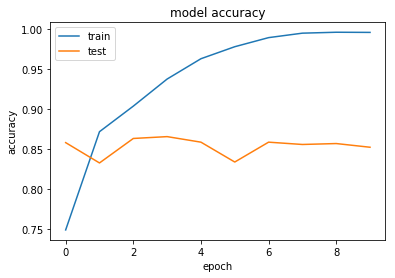

In [58]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

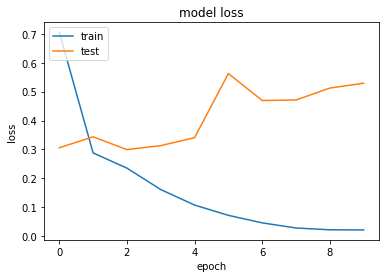

In [59]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Baseline Model with Multi-Layer Perceptron

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

Using TensorFlow backend.


In [43]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [44]:
# flatten 406, 438 images to a 177828 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [45]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [46]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [47]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [48]:
# build the model
model_1 = baseline_model()

In [49]:
%%time
# Fit the model
history = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Train on 5205 samples, validate on 1735 samples
Epoch 1/10
 - 90s - loss: 6.1658 - acc: 0.6111 - val_loss: 6.1609 - val_acc: 0.6156
Epoch 2/10
 - 76s - loss: 5.9841 - acc: 0.6269 - val_loss: 6.1256 - val_acc: 0.6184
Epoch 3/10
 - 79s - loss: 5.9594 - acc: 0.6294 - val_loss: 6.0961 - val_acc: 0.6190
Epoch 4/10
 - 79s - loss: 5.9411 - acc: 0.6302 - val_loss: 6.1038 - val_acc: 0.6196
Epoch 5/10
 - 74s - loss: 5.9115 - acc: 0.6327 - val_loss: 6.0508 - val_acc: 0.6231
Epoch 6/10
 - 80s - loss: 5.9156 - acc: 0.6323 - val_loss: 6.0479 - val_acc: 0.6231
Epoch 7/10
 - 78s - loss: 5.9192 - acc: 0.6317 - val_loss: 6.0590 - val_acc: 0.6225
Epoch 8/10
 - 78s - loss: 5.8844 - acc: 0.6340 - val_loss: 6.0275 - val_acc: 0.6242
Epoch 9/10
 - 79s - loss: 5.8956 - acc: 0.6330 - val_loss: 5.9692 - val_acc: 0.6288
Epoch 10/10
 - 79s - loss: 5.8492 - acc: 0.6367 - val_loss: 5.9838 - val_acc: 0.6277
CPU times: user 55min 39s, sys: 16min 40s, total: 1h 12min 20s
Wall time: 13min 12s


In [50]:
# Final evaluation of the model
scores = model_1.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 37.23%


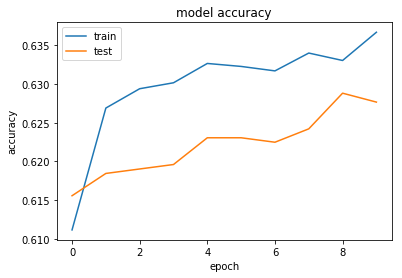

In [51]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

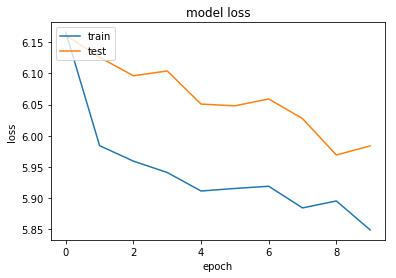

In [97]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model_1.predict_classes(X_test, batch_size=10)

In [51]:
def classify_image(i, predictions, X=X, y=y):
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.25, random_state=42)
    plt.imshow(X_test_orig[i])
    print("prediction:", ['no_building', 'building'][predictions[i]])
    print("actual:", ['no_building', 'building'][y_test_orig[i]])

prediction: building
actual: building


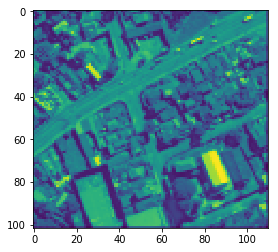

In [56]:
classify_image(0, predictions)

prediction: building
actual: building


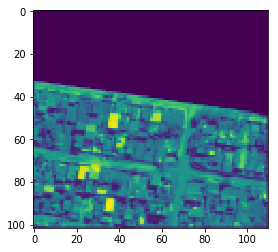

In [84]:
classify_image(1000, predictions)

In [85]:
model_1.save(join("models", "model_1.h5"))

# Larger Convolutional Neural Network

In [73]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# reshape to be [samples][bands][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, X_train[0].shape[0], X_train[0].shape[1]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, X_test[0].shape[0], X_test[0].shape[1]).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [86]:
# define the larger model
def larger_cnn():
    # create model
    model = Sequential()
    model.add(Conv2D(50, (5, 5), input_shape=(1, X_train.shape[2], X_train.shape[3]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [87]:
%%time
# build the model
model_3 = larger_cnn()
# Fit the model
history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=50, verbose=2)
# Final evaluation of the model
scores = model_3.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 5205 samples, validate on 1735 samples
Epoch 1/10


KeyboardInterrupt: 

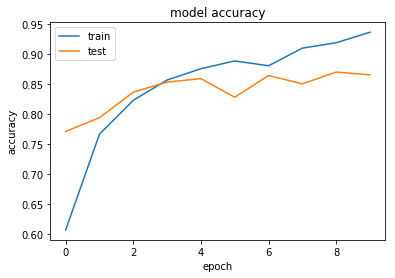

In [88]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

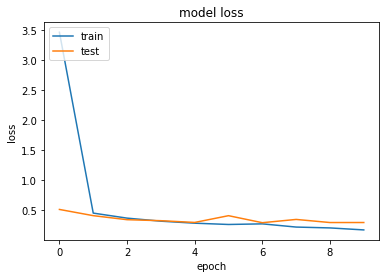

In [89]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Demo a few images.

In [90]:
predictions = model_3.predict_classes(X_test, batch_size=10)

prediction: building
actual: building


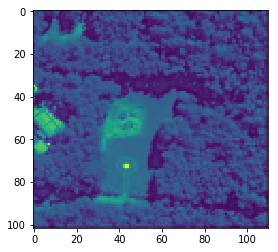

In [91]:
classify_image(23, predictions)

Visualize model architecture.